In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import re
import string
import unicodedata
import plotly_express as px
import plotly.io as pio
from sklearn import preprocessing
import pandas_profiling
import datetime
%matplotlib inline
import matplotlib.style
import matplotlib as mpl
import matplotlib.pyplot as plt 
from sklearn import preprocessing
import warnings
import math

warnings.filterwarnings("ignore")


In [2]:
df_count_day_type = pd.read_csv('./data_joao/df_count_day_type_modificado.csv',sep=",",parse_dates=['judgmentDate'])
df_count_week_day_type = pd.read_csv('./data_joao/df_count_week_day_type_modificado.csv',sep=",")
df_count_year_month_type = pd.read_csv('./data_joao/df_count_year_month_type_modificado.csv',sep=",")

df_count_day_type.index = pd.to_datetime(df_count_day_type['judgmentDate'])
df_count_year_month_type.index = pd.to_datetime(df_count_year_month_type['yearMonth'])
#df_count_week_day_type.index = pd.to_datetime(df_count_week_day_type['weekDay'])

del df_count_day_type['Unnamed: 0']
del df_count_week_day_type['Unnamed: 0']
del df_count_year_month_type['Unnamed: 0']
del df_count_day_type['judgmentDate']
del df_count_year_month_type['yearMonth']

dataFrames = [df_count_day_type,df_count_week_day_type,df_count_year_month_type]
for df in dataFrames:
    display(df.head(2))
    display(df.index)

,type,count,weekDay,weekType,Dia,Mes,Ano,Feriado
judgmentDate,,,,,,,,
2000-01-03,Agravo de Instrumento,2,0,DiaSemana,3,1,2000,False
2000-01-06,Agravo de Instrumento,1,3,DiaSemana,6,1,2000,False


DatetimeIndex(['2000-01-03', '2000-01-06', '2000-01-10', '2000-01-11',
               '2000-01-20', '2000-01-24', '2000-02-02', '2000-02-06',
               '2000-02-07', '2000-02-08',
               ...
               '2017-12-21', '2017-12-21', '2017-12-27', '2017-12-28',
               '2017-12-28', '2017-12-28', '2017-12-29', '2017-12-29',
               '2017-12-29', '2017-12-29'],
              dtype='datetime64[ns]', name='judgmentDate', length=63765, freq=None)

,weekDay,type,count
0,Sun,Ação Civil Pública,2
1,Sun,Ação Rescisória,9


RangeIndex(start=0, stop=513, step=1)

,type,count
yearMonth,,
2000-01-01,Agravo de Instrumento,12
2000-02-01,Ação Rescisória,1


DatetimeIndex(['2000-01-01', '2000-02-01', '2000-02-01', '2000-02-01',
               '2000-02-01', '2000-02-01', '2000-02-01', '2000-02-01',
               '2000-02-01', '2000-02-01',
               ...
               '2017-12-01', '2017-12-01', '2017-12-01', '2017-12-01',
               '2017-12-01', '2017-12-01', '2017-12-01', '2017-12-01',
               '2017-12-01', '2017-12-01'],
              dtype='datetime64[ns]', name='yearMonth', length=7455, freq=None)


<div class="alert alert-info"><h1> Análise de Tendência
</h1>
    <hr/>
    <h4> SatsModels </h4>
</div>


In [3]:
from statsmodels.tsa.filters.hp_filter import hpfilter

#Agrupa todas as informações 
print('Antes do agrupamento: ',df_count_day_type['count'].count())
df_count_day_type_grp = df_count_day_type.groupby('judgmentDate').agg({'count':'sum'})
df_count_year_month_type_grp = df_count_year_month_type.groupby('yearMonth').agg({'count':'sum'})
print('Depois do agrupamento: ',df_count_day_type_grp.count())

Antes do agrupamento:  63765
Depois do agrupamento:  count    5790
dtype: int64


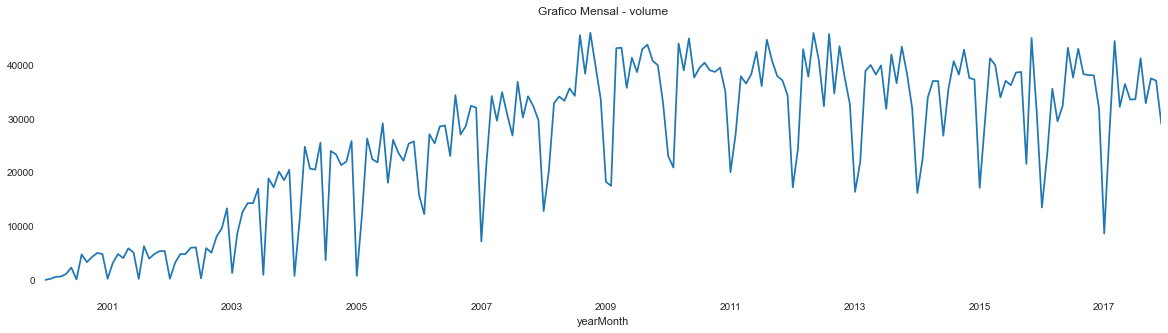

In [4]:
df_count_year_month_type_grp['count'].plot.line(figsize=(20,5),title='Grafico Mensal - volume')

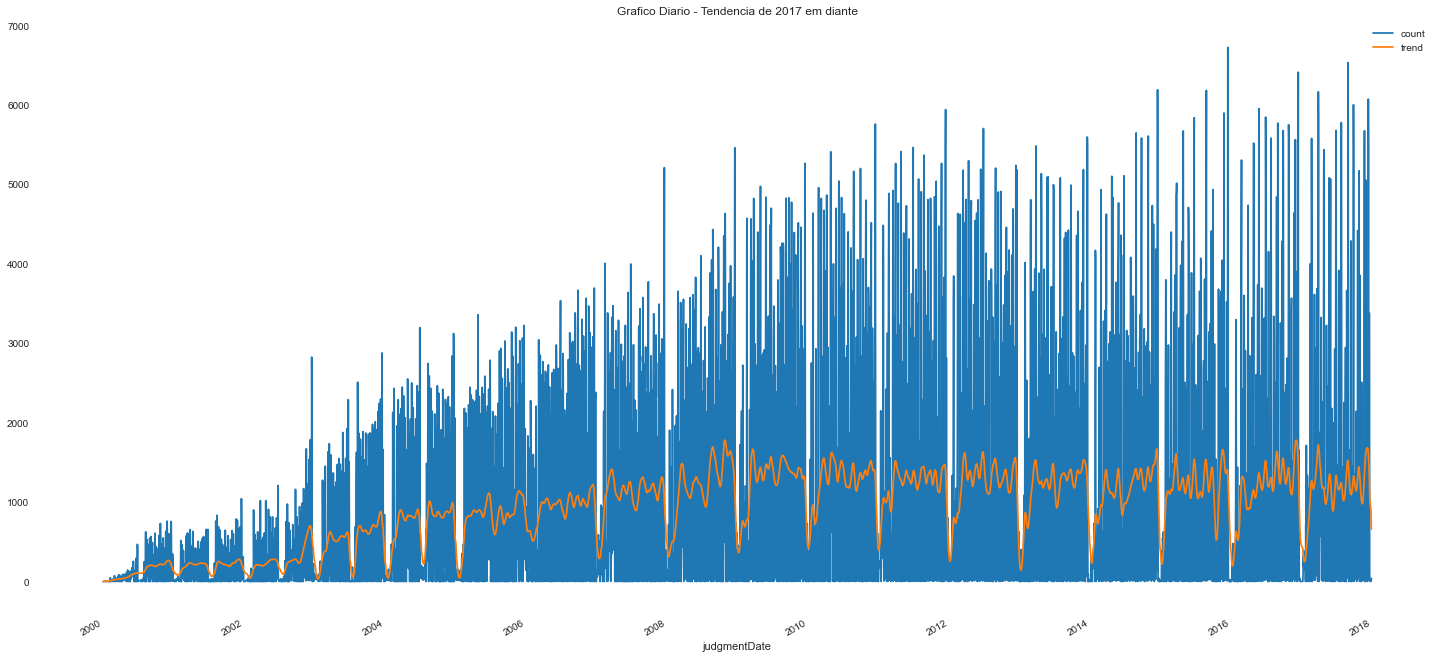

In [5]:
from statsmodels.tsa.filters.hp_filter import hpfilter
#Verificar Tendencia
year_cycle,year_trend = hpfilter(df_count_year_month_type_grp['count'],lamb=1600)
day_cycle,day_trend = hpfilter(df_count_day_type_grp['count'],lamb=1600)

df_count_day_type_grp['trend'] = day_trend
df_count_year_month_type_grp['trend'] = year_trend

df_count_day_type_grp[['count','trend']][:].plot.line(figsize=(25,12),title='Grafico Diario - Tendencia de 2017 em diante')


,count,trend
yearMonth,,
2000-01-01,12,716.351039
2000-02-01,222,942.719092
2000-03-01,576,1168.646925


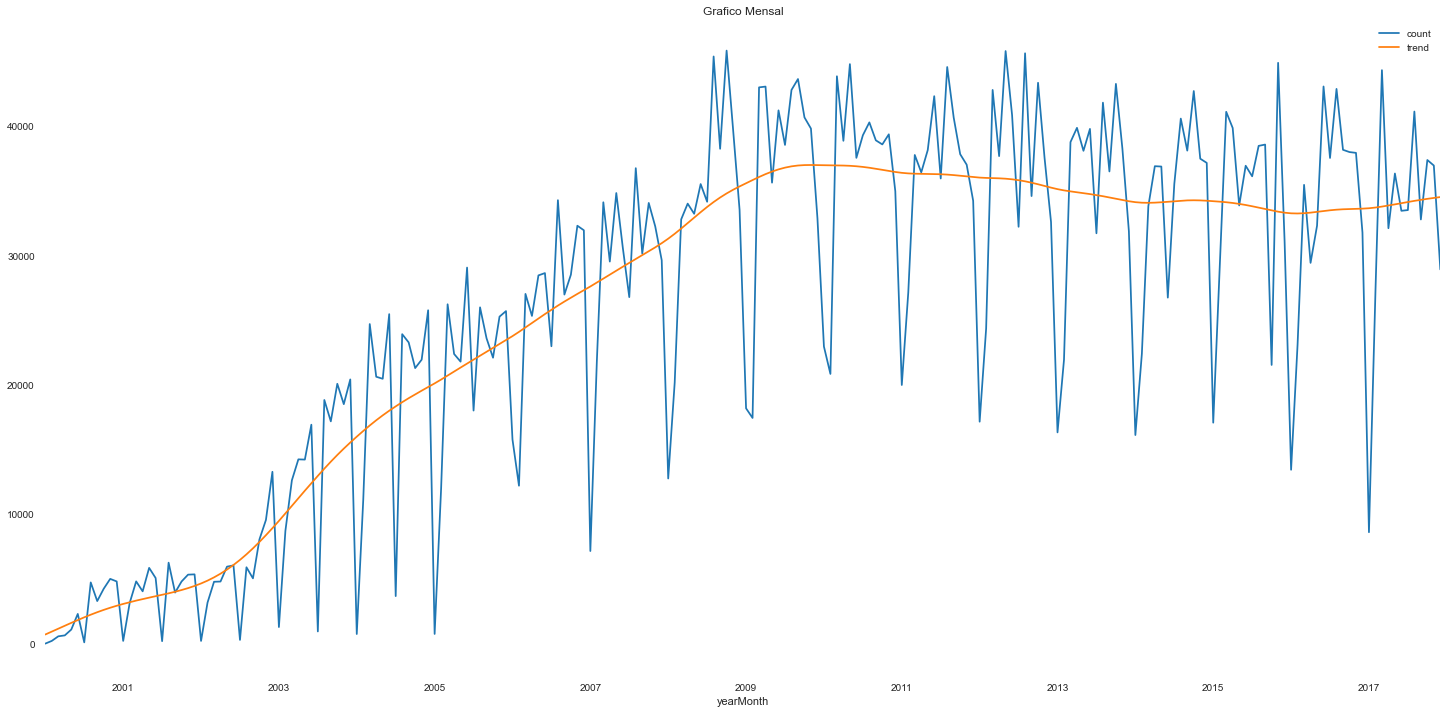

In [6]:
display(df_count_year_month_type_grp.head(3))
#df_t_YM[['count','trend']]['2017-11-01':].plot.line(figsize=(25,10))
df_count_year_month_type_grp[['count','trend']].plot.line(figsize=(25,12),title='Grafico Mensal');


<div class="alert alert-info"><h1> ETS
</h1>
    <hr/>
</div>


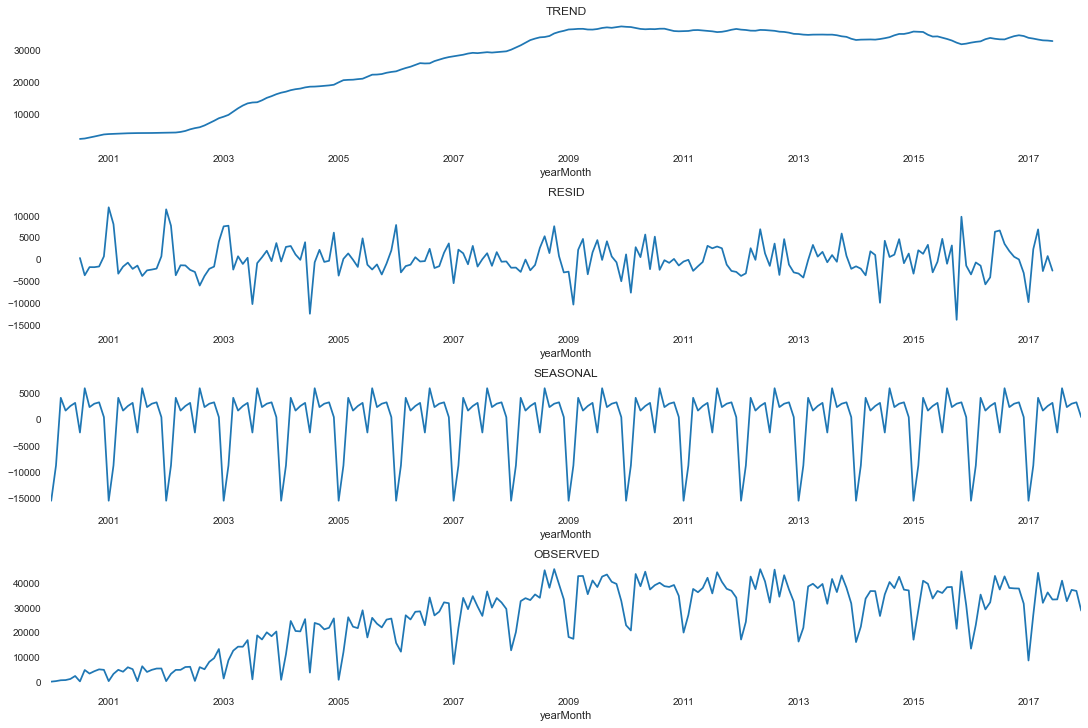

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt 

#multiplicative usar quando é exponencial
#add usar quando é linear 

#result_YM = seasonal_decompose(df_t_YM_ets['count'],model='multiplicative')
result_YM = seasonal_decompose(df_count_year_month_type_grp['count'],model='additive')

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(15,10), constrained_layout=True)
result_YM.trend.plot(ax=ax1,title='TREND')
result_YM.resid.plot(ax=ax2,title='RESID')
result_YM.seasonal.plot(ax=ax3,title='SEASONAL')
result_YM.observed.plot(ax=ax4,title='OBSERVED');


<div class="alert alert-info"><h1> EWMA
</h1>
    <hr/>
</div>

,yearMonth,count
yearMonth,,
2000-01-01,2000-01-01 00:00:00.000,12
2000-02-01,2000-02-01 00:00:00.000,222
2000-03-01,2000-03-01 00:00:00.000,576


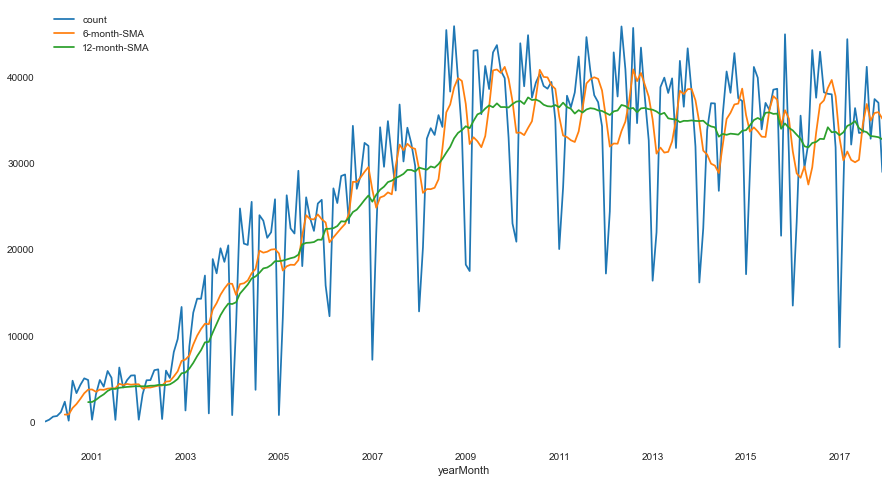

In [8]:
#Não está sendo feito por tipo, mas sim o todo. Fica muito poluido com todos

df_ewma_YM_aux =df_count_year_month_type_grp.reset_index()
df_ewma_YM_aux['yearMonth'] = pd.to_datetime(df_ewma_YM_aux['yearMonth']).dt.to_period('D')

#df_ewma_YM_aux[['yearMonth','count']].groupby(['yearMonth']).agg({'count':'sum'}).head(3)
df_ewma_year_grp = df_ewma_YM_aux[['yearMonth','count']].groupby(['yearMonth']).agg({'count':'sum'}).reset_index()
df_ewma_year_grp['yearMonth'] = df_ewma_year_grp['yearMonth'].dt.to_timestamp('s').dt.strftime('%Y-%m-%d %H:%M:%S.000')
df_ewma_year_grp.index = pd.to_datetime(df_ewma_year_grp['yearMonth'])
display(df_ewma_year_grp.head(3))

df_ewma_year_grp['6-month-SMA'] = df_ewma_year_grp['count'].rolling(window=6).mean()
df_ewma_year_grp['12-month-SMA'] = df_ewma_year_grp['count'].rolling(window=12).mean()
del df_ewma_year_grp['yearMonth']
df_ewma_year_grp.plot.line(figsize=(15,8));

<div class="alert alert-warning">    
    <h4>Grafico acima a média não alcança os picos ...  </h4>        
    <hr/>    
</div>

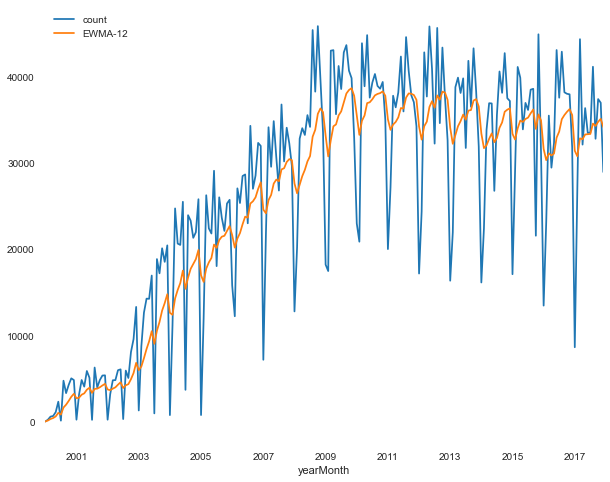

In [9]:
df_ewma_year_grp['EWMA-12'] = df_ewma_year_grp['count'].ewm(span=12).mean()
df_ewma_year_grp[['count','EWMA-12']].plot(figsize=(10,8));


<div class="alert alert-info"><h1> Holt - Winters Methods
</h1>
    <hr/>
    <h3> Pegando apenas um dos tipos, se não fica impossivel analisar. 
</h3>
</div>

In [10]:
df_Holt_YM = df_count_year_month_type[df_count_year_month_type['type']=='Agravo de Instrumento']


In [11]:
df_Holt_YM.fillna(0,inplace=True)
df_Holt_YM.index.asfreq = 'A'

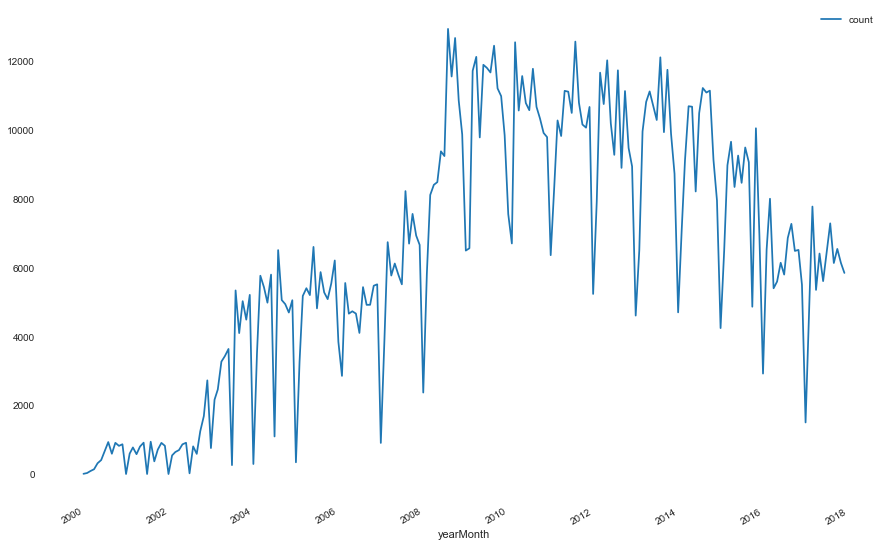

In [12]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
df_Holt_YM.plot(figsize=(15,10));

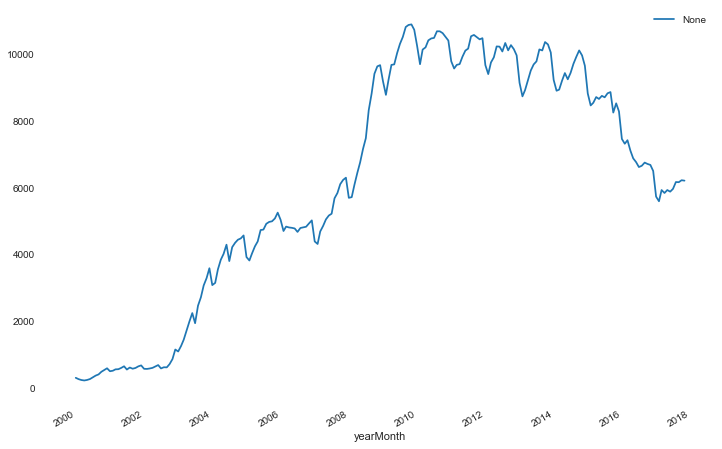

In [21]:
span = 12 
alpha = 2/(span+1)
df_Holt_YM['EWMA12T'] = df_Holt_YM['count'].ewm(alpha=alpha,adjust=True).mean()
df_Holt_YM['EWMA12F'] = df_Holt_YM['count'].ewm(alpha=alpha,adjust=False).mean()
df_Holt_YM.head()
model = SimpleExpSmoothing(df_Holt_YM['count'])
fitted_model = model.fit(smoothing_level=alpha, optimized=True)
fitted_model.fittedvalues.shift(-1).plot(legend=True,figsize=(12,8));


In [14]:
df_Holt_YM['SES12']=SimpleExpSmoothing(df_Holt_YM['count']).fit(smoothing_level=alpha, optimized=False).fittedvalues.shift(-1)
df_Holt_YM

,type,count,EWMA12,SES12
yearMonth,,,,
2000-01-01,Agravo de Instrumento,12,12.000000,12.000000
2000-02-01,Agravo de Instrumento,35,15.538462,15.538462
2000-03-01,Agravo de Instrumento,93,27.455621,27.455621
2000-04-01,Agravo de Instrumento,145,45.539372,45.539372
2000-05-01,Agravo de Instrumento,319,87.610238,87.610238
...,...,...,...,...
2017-08-01,Agravo de Instrumento,7286,6163.789056,6163.789056
2017-09-01,Agravo de Instrumento,6134,6159.206125,6159.206125
2017-10-01,Agravo de Instrumento,6543,6218.251336,6218.251336


In [15]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

df_Holt_YM['DES_add_12'] = ExponentialSmoothing(df_Holt_YM['count'],trend='add').fit().fittedvalues.shift(-1)
df_Holt_YM['DES_mul_12'] = ExponentialSmoothing(df_Holt_YM['count'],trend='mul').fit().fittedvalues.shift(-1)
df_Holt_YM.head()

,type,count,EWMA12,SES12,DES_add_12,DES_mul_12
yearMonth,,,,,,
2000-01-01,Agravo de Instrumento,12,12.000000,12.000000,60.901477,321.187584
2000-02-01,Agravo de Instrumento,35,15.538462,15.538462,81.840400,137.434460
2000-03-01,Agravo de Instrumento,93,27.455621,27.455621,114.022622,75.917452
2000-04-01,Agravo de Instrumento,145,45.539372,45.539372,152.217006,63.283143
2000-05-01,Agravo de Instrumento,319,87.610238,87.610238,231.611030,101.106020


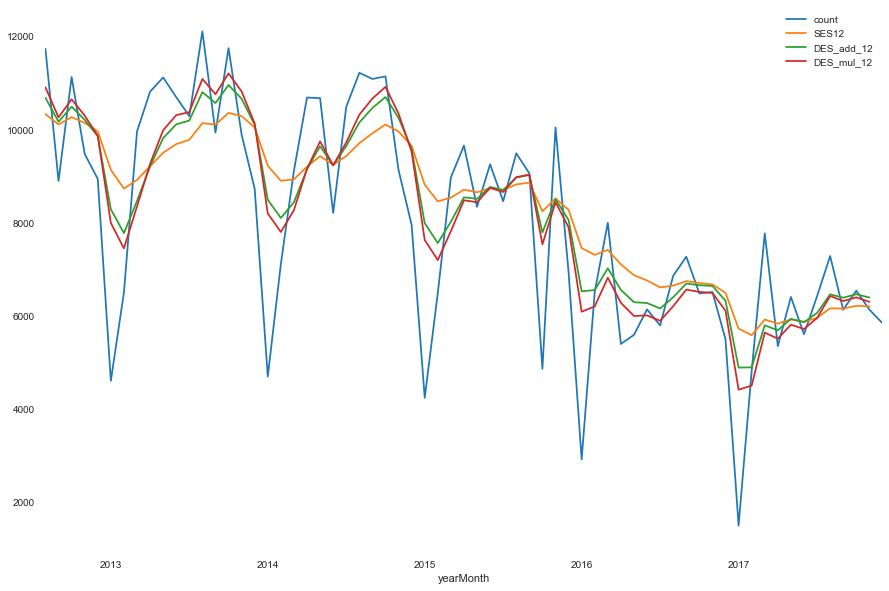

In [16]:
df_Holt_YM[['type', 'count', #'6-month-SMA', '12-month-SMA', 'EWMA12'
             'SES12','DES_add_12','DES_mul_12']].iloc[150:].plot(figsize=(15,10));

## Seasonal

,type,count,EWMA12,SES12,DES_add_12,DES_mul_12,TES_add_12
yearMonth,,,,,,,
2000-01-01,Agravo de Instrumento,12,12.000000,12.000000,60.901477,321.187584,68.671926
2000-02-01,Agravo de Instrumento,35,15.538462,15.538462,81.840400,137.434460,201.409118
2000-03-01,Agravo de Instrumento,93,27.455621,27.455621,114.022622,75.917452,287.232950
2000-04-01,Agravo de Instrumento,145,45.539372,45.539372,152.217006,63.283143,364.447820
2000-05-01,Agravo de Instrumento,319,87.610238,87.610238,231.611030,101.106020,551.725953
...,...,...,...,...,...,...,...
2017-08-01,Agravo de Instrumento,7286,6163.789056,6163.789056,6463.859612,6428.822990,7470.909250
2017-09-01,Agravo de Instrumento,6134,6159.206125,6159.206125,6392.586104,6321.122777,7050.469830
2017-10-01,Agravo de Instrumento,6543,6218.251336,6218.251336,6467.014200,6399.294900,5662.016092


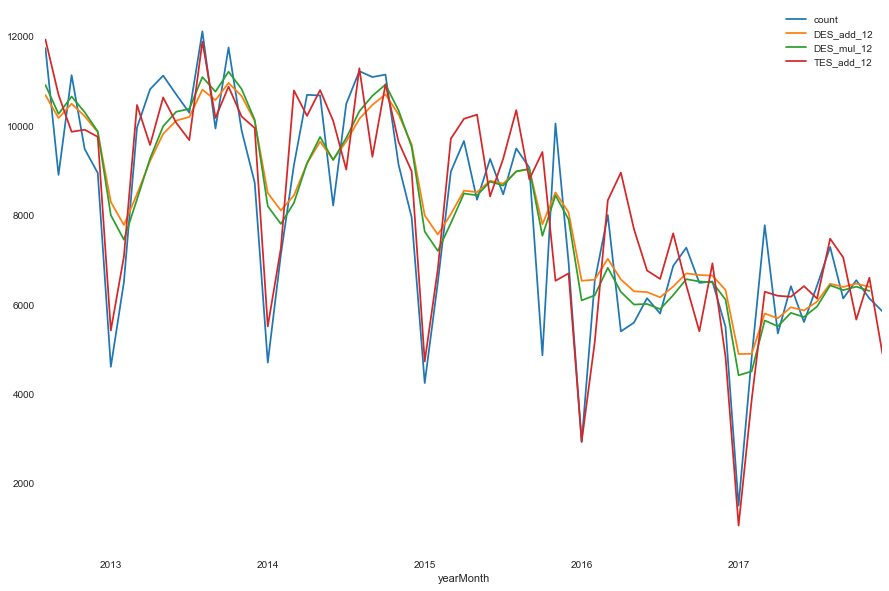

In [17]:
df_Holt_YM['TES_add_12'] = ExponentialSmoothing(df_Holt_YM['count'],trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues
df_Holt_YM[['type', 'count', #'6-month-SMA', '12-month-SMA', 'EWMA12'
            # 'SES12',
            'DES_add_12',
            'DES_mul_12','TES_add_12']].iloc[150:].plot(figsize=(15,10));
df_Holt_YM